In [1]:
%matplotlib inline

# We use CAMB generated scalar C_l values, N_side=8
# and CAMB simulated maps associated with scalar C_l values above
# N_side=8 gives N_pix=768



In [2]:
# http://healpy.readthedocs.org/en/latest/generated/healpy.sphtfunc.anafast.html
#
# lmax = (3*Nside - 1)
#
# if lmax=0, there is only one Cl, i.e. C0. If lmax=11, there are 12 Cl values, 
# Cl= [C0, C1 ... C11]


In [3]:
# The standard I am using is lmax = (3*Nside - 1)
#
# However, for all computations, we CONSISTENTLY remove monopole and dipole terms
# Otherwise, we end up dividing by zero
#
# So, generate FITS with lmax = 3Nside+1

In [4]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function

np.set_printoptions(threshold=1000)  # Default is threshold=1000
## Use this to print all values, disables corner printing

In [5]:
cd ~/downloads

/Users/evanbiederstedt/Downloads


In [6]:
filename = "camb_cls_nside8_lmax25.fits" # CAMB C_l scalars
temp = "camb_map_nside8_lmax25.fits" # CAMB simulated maps
nside = 8

In [7]:
npix = 12*(nside**2) #total number of pixels, npix
lmax = ((3*nside)-1) #maximum l of the power spectrum C_l

In [8]:
# open a FITS file 
# type()=pyfits.hdu.hdulist.HDUList
ff = pf.open(filename)

In [9]:
### Recall there are four columns: temp, E pol, B pol, grad-temp cross terms
## first two values are zero, i.e. monopole, dipole
cls = ff[1].data  # actually second HDU, first is empty


In [10]:
# XXX.field() references columns by 0-index
# field(0) is temperature values
# all Cl scalar temp values put into ndarray
# type()=numpy.ndarray

cltemp = cls.field(0) 
newcls = np.delete( cltemp, [0,1] )


# Note: imported C_l values 3*Nside + 1 = cltemp
# newcls uses lmax = 3Nside - 1



print len(cltemp)
print "the number of l values: l=0, l=1, ... l=lmax, where lmax="
print lmax
print "this means length"
print len(newcls) #the l=0 value

26
the number of l values: l=0, l=1, ... l=lmax, where lmax=
23
this means length
24


In [11]:
# define ell values
# array from 0 to lmax, where lmax = 
# add two values in case there are issues with monopole, dipole term
ellval = np.arange(len(cltemp))


In [12]:
# P_0 is the monopole, P_1 is the dipole
# remove 0, 1

newellval = np.delete(ellval, [0,1]) #numpy.ndarray

print ellval
print newellval

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]


In [13]:
# First calculate the covariance matrix by the definition, i.e. 
# 
# C_ij = < \delta T_i \delta T_j > = 1/4pi \sum^{N_pix} p = 
# ( T_i(p) - mean(T_i) ) * ( T_j(p) - mean(T_j) )
#
#
# Larson, Weiland, Hinshaw, Bennett, 
# http://arxiv.org/pdf/1409.7718.pdf
#

In [14]:
tempmap = hp.mrdfits(temp) #type() = list


In [15]:
tempval = tempmap[0][:] #len()=12288, type()=numpy.ndarray

# len(tempval) = 12
# 1024 * 12 = 12288
# 12 rows of 1024 entries

# tempval.shape = (12, 1024)

In [16]:
# The HEALPix standard is fixed at shape = (n, 1024)
# Columns are consistently 1024
# Rows vary
#
# Concatenate array so it is one-dimensional
#
#
# Could use numpy.reshape
# Quicker, probably
# np.reshape(tempval, (1, -1))
#

if npix < 1024: 
    tempdata = tempval
else:
    tempdata = np.concatenate([tempval[i,:] for i in range(tempval.shape[0])])


In [17]:
tempdata.shape

(768,)

In [18]:
### Begin calculating S_ij piece by piece, in order to do the summation correctly 
#
# S_ij = sum(2ell+1) C_l P_l(dotproductmatrix)

In [19]:

totalpix = np.arange(npix) 
#print ell = [    0     1     2 ..., 3071, 3072]

In [20]:
## healpy.pixelfunc.pix2vec(nside, ipix, nest=False)
## 
## will give three arrays
## arrays of all x values, all y values, all z values
## RING scheme default
# len()=3
# type()=tuple
#
#

vecval = hp.pix2vec(nside, totalpix) #Nside = 16, type()=tuple


In [21]:
vecvalx = vecval[0] #shape (3072,)
vecvaly = vecval[1]
vecvalz = vecval[2]



In [22]:
## First arrange arrays vertically
## numpy.vstack = Stack arrays in sequence vertically (row wise), input sequence of arrays

totalvecval = np.vstack((vecvalx, vecvaly, vecvalz)) #type()=numpy.ndarray

In [23]:
trans = totalvecval.T #transpose


In [24]:
dotproductmatrix = trans.dot(totalvecval) #take the dot product
#dotproductmatrix.shape = (npix, npix)




In [25]:
## Begin calculating S_ij piece by piece, in order to do the summation correctly. 
#
# S_ij = sum(2ell+1) C_l P_l(dotproductmatrix)

# NOT QUICK!

summatrix = np.sum( [eval_legendre(i, dotproductmatrix) for i in newellval], axis=0)
#
# numpy.sum(a, axis=None, dtype=None, out=None, keepdims=False)[source]
# a : array_like
# Elements to sum.
# axis : None or int or tuple of ints, optional
# Axis or axes along which a sum is performed. 
# The default (axis = None) is perform a sum over all the dimensions of the input array. 
# axis may be negative, in which case it counts from the last to the first axis.
#


print summatrix.shape


(768, 768)


In [26]:
# matrix_total = 
# (1/(4*math.pi)) * sum((2 * ll + 1) * cltemp ) * eval_legendre(ll, matrix_dotprod)
#
# Begin with adding theoretical scalar C_l values
#
add_clvalues = np.sum([ i * summatrix for i in newcls ], axis=0)


In [27]:
# matrix_total = 
# (1/(4*math.pi)) * np.sum((2*ll + 1) * cltemp ) * eval_legendre(ll, matrix_dotprod)

wholematrix = np.sum([((2 * i) + 1) * add_clvalues for i in newellval ], axis=0)



In [28]:

covmatrix = (1/(4 * math.pi)) * wholematrix #covariance matrix for Nside=4



In [29]:
# We now compute likelihood functions
#
# For equations, refer to Nside4_covariance_likelihood.tex
# "Nside = 4: Covariance and likelihood"
#


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(768,)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/sphtfunc.py:294: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


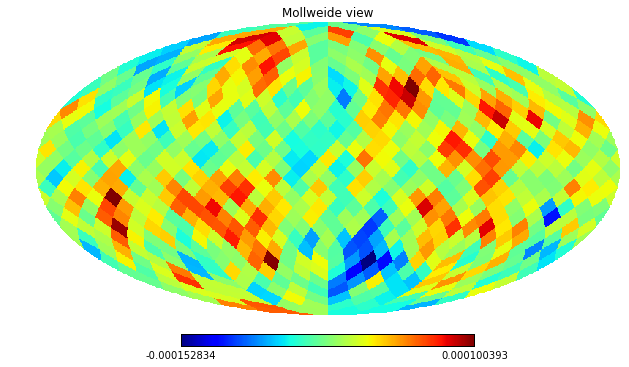

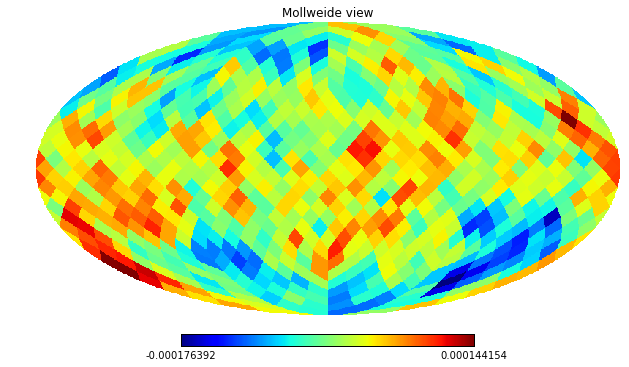

In [30]:
map1 = hp.synfast(newcls, nside)
map2 = hp.synfast(cltemp, nside)


print map1.shape
tempentries = map2

### healpy.sphtfunc.synfast(cls, nside, lmax=None, mmax=None, alm=False, pol=True, 
###                         pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)
# INPUT cls, nside
# OUTPUT sky maps
viewmap = hp.mollview(map1) ##this map DOES NOT contains monopole, dipole
viewmap2 = hp.mollview(map2) ##this map DOES INDEED contain monopol, dipole

In [31]:
powerspectrum = hp.anafast(map1) # create powerspectrum \hat{C}_l
pwer2 = hp.anafast(map2)
print len(powerspectrum)
print powerspectrum
print len(pwer2)
print pwer2
print "***"
print "Notice the first two values, power e-18 and e-16, monopole and dipole"

24
[  1.12355936e-09   6.35000096e-11   5.76361085e-10   9.01659305e-11
   2.53208068e-10   9.71681232e-11   7.01352432e-11   4.60026004e-11
   4.06261016e-11   3.54616487e-11   3.74326814e-11   3.52330721e-11
   2.53007618e-11   2.06949060e-11   2.13590086e-11   2.46328258e-11
   2.28979595e-11   1.12303821e-11   1.66532115e-11   1.00691146e-11
   1.38264874e-11   1.11400101e-11   9.39757895e-12   5.18054425e-12]
24
[  3.90234310e-17   8.09154710e-18   2.01499495e-09   4.05722541e-10
   2.73763217e-10   1.66589636e-10   2.09253108e-10   1.37001931e-10
   8.05225400e-11   7.00840538e-11   4.19832286e-11   4.69584196e-11
   4.84270470e-11   2.38062829e-11   2.85952667e-11   2.12935840e-11
   1.19283849e-11   1.73142825e-11   1.53827401e-11   1.91096854e-11
   1.43763826e-11   1.56026103e-11   8.62828802e-12   1.04796169e-11]
***
Notice the first two values, power e-18 and e-16, monopole and dipole


In [41]:
print "Evaluate spherical harmonic likelihood function"
print "-2\ln L = \sum_{l}(2l+1)\Big[\ln\Big( \frac{C^{\text{th}}_l}{\hat{C}_l}\Big) +\Big(\hat{C}_l/C^{\text{th}}_l\Big)-1 \Big]"
print "where HEALPix anafast is \hat(C)_l, frac{1}{2l+1}\sum_m \vert\hat{a}_{lm}\vert^2"



print "****"
print "We foolishly guess-timate Sum_ell(2*ell +1)"
print "Calculate sum( [(2*i + 1) for i in ell])"
estimatesum = np.sum( [(2*i + 1) for i in newellval], axis=0) #newellval HAS NO monopole, dipole
print "Our crazy guess is something around the value="
print estimatesum

#C^th_l is newcls, NO MONOPOLE, NO DIPOLE
#\hat(C)_l is powerspectrum = hp.anafast(map1), where map1 = hp.synfast(newcls, nside)
#type(newcls) = numpy.ndarray
#type(powerspectrum) = numpy.ndarray
spherlikepart = ( (np.log(newcls/powerspectrum)) + (powerspectrum/newcls) - 1 )
print spherlikepart.shape

sphericalharmoniclikelihood = np.sum( [(2*i +1 ) * spherlikepart for i in newellval])

print sphericalharmoniclikelihood

print "**************"
print "**************"


Evaluate spherical harmonic likelihood function
-2\ln L = \sum_{l}(2l+1)\Big[\ln\Big( rac{C^{	ext{th}}_l}{\hat{C}_l}\Big) +\Big(\hat{C}_l/C^{	ext{th}}_l\Big)-1 \Big]
where HEALPix anafast is \hat(C)_l, frac{1}{2l+1}\sum_m ert\hat{a}_{lm}ert^2
****
We foolishly guess-timate Sum_ell(2*ell +1)
Calculate sum( [(2*i + 1) for i in ell])
Our crazy guess is something around the value=
672
(24,)
1662.18252139
**************
**************


In [33]:
# Compute temperature space (real space) likelihood
#
# where T is a temperature map array (3072,), S is our above matrix = entirething, 
# and N is the number of pixels in a vector
#
# First Year Wilkinson Microwave Anisotropy Probe (WMAP) Observations: 
# Parameter Estimation Methodology L. Verde, et al., 2003, ApJS, 148, 195
#
# http://lambda.gsfc.nasa.gov/product/map/dr1/
# pub_papers/firstyear/methodology/wmap_param_method.pdf
#
# print "−2 ln L \propto T*S^{-1}*T + ln detS + N ln 2\pi"

In [34]:
tempvalues = np.matrix(tempentries) #create matrix of temperature values from CAMB map
# tempvalues.shape = (1, 192)
print tempvalues.shape

(1, 768)


In [35]:
temptranspose = tempvalues.T
# temptranspose.shape = (192, 1)

In [36]:
## Invert covariance matrix, S_ij
## numpy.linalg.inv(a)
## Compute the (multiplicative) inverse of a matrix.
## Given a square matrix a, return the matrix ainv satisfying 
## dot(a, ainv) = dot(ainv, a) = eye(a.shape[0]).
##

inverse = np.linalg.inv(covmatrix)
inversematrix = np.matrix(inverse) # S^{-1}
inversematrix.shape

(768, 768)

In [37]:
# WARNING: DO NOT USE NP.LIGALG.DET(A)! 
# Operatioin will not succeed, gives inf or zero
#
#
#
# numpy.linalg.slogdet
# numpy.linalg.slogdet(a)[source]
# Compute the sign and (natural) logarithm of the determinant of an array.
# INPUT array
# OUTPUT (sign, ln det a)
# sign = A number representing the sign of the determinant. 
# For a real matrix, this is 1, 0, or -1. 
# For a complex matrix, this is a complex number with absolute value 1 (i.e., it is on the unit circle), or else 0.
# ln det a = The natural log of the absolute value of the determinant.
#
lnDetS = np.linalg.slogdet(inversematrix) #type()=tuple
print lnDetS 
type(lnDetS[1])

(1.0, 12963.490901780076)


numpy.float64

In [38]:
type(temptranspose)
temptranspose.shape

(768, 1)

In [39]:
realtemplikehd = ( tempvalues * inversematrix * temptranspose ) 
realtemplikehdpt2 = ( tempvalues * inversematrix * temptranspose ) + lnDetS[1]
realtemplikehdpt3 = ( tempvalues * inversematrix * temptranspose ) + ( lnDetS[1] ) + ((192)*2*math.pi)

In [40]:
print "Real space (temperature space) likelihood function"
print "Formalism:  −2 ln L \propto T*S^{-1}*T + ln detS + N ln 2\pi"
print "First number: T*S^(-1)*T "

print realtemplikehd

print "Second number: T*S^{-1}*T + ln detS "

print realtemplikehdpt2

print "Third number:  −2 ln L \propto T*S^{-1}*T + ln detS + N ln 2\pi"

print realtemplikehdpt3

print "**************"
print "**************"
print "END"

Real space (temperature space) likelihood function
Formalism:  −2 ln L \propto T*S^{-1}*T + ln detS + N ln 2\pi
First number: T*S^(-1)*T 
[[ 0.27299535]]
Second number: T*S^{-1}*T + ln detS 
[[ 12963.76389713]]
Third number:  −2 ln L \propto T*S^{-1}*T + ln detS + N ln 2\pi
[[ 14170.13547611]]
**************
**************
END
